# Определение стоимости автомобилей

<div class="alert alert-info" style="border:solid purple 2px; padding: 20px; background-color: #e6d2f2; color: #4b0082;">

**Цель исследования**: построить модель, которая будет определять рыночную стоимость автомобилей.

**Задачи исследования**:
- изучить данные
- проверить данные на пропуски, выбросы и аномалии
- обучить модели
- подобрать гиперпараметры для моделей
- найти модель, которая будет соответствовать критериям заказчика

## Подготовка данных

**1. Импортирую все нужные в работе библиотеки**

In [1]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

**2. Открою файл с данными**

In [2]:
path_to_file = 'C:/Users/Naiana/Desktop/DS projects/autos.csv'
data = pd.read_csv(path_to_file)

**3. Изучу данные**

In [3]:
#посмотрим дату скачивания анкеты из базы
data['DateCrawled'] = pd.to_datetime(data['DateCrawled'], format='%Y-%m-%d %H:%M:%S')
data['DateCrawled'].describe(datetime_is_numeric=True)

count                           354369
mean     2016-03-21 12:58:10.450648320
min                2016-03-05 14:06:22
25%                2016-03-13 11:52:33
50%                2016-03-21 17:50:55
75%                2016-03-29 14:37:20
max                2016-04-07 14:36:58
Name: DateCrawled, dtype: object

<div class="alert alert-info" style="border:solid purple 2px; padding: 20px; background-color: #e6d2f2; color: #4b0082;">

Данные выгружены в 2016 году.

**3.1.** info

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  object        
 13  NumberOfPictures   354369 non-null  int64   

<div class="alert alert-info" style="border:solid purple 2px; padding: 20px; background-color: #e6d2f2; color: #4b0082;">

- В данных есть признаки формата object и int64. 
- Присутствуют пропуски 
- Присутствуют неинформативные признаки. Т.к. признак либо влияет на рыночную стоимость, либо нет, смысла проверять данные на корреляцию с целевым признаком нет. Выделю неинформативные признаки и удалю их.

In [5]:
#создадим переменную, в которую сохраним неинформативные признаки
data_drop = ['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen']

#удалим их
data = data.drop(data_drop, axis=1)

**3.2.** head

In [6]:
data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


**3.3.** Дубликаты

In [7]:
data.duplicated().sum()

45040

In [8]:
#удалим дубликаты
data = data.drop_duplicates()

data.duplicated().sum()

0

**3.4.** Корреляция

<div class="alert alert-info" style="border:solid purple 2px; padding: 20px; background-color: #e6d2f2; color: #4b0082;">

Рассмотрю корреляцию признаков с целевым признаком.

In [9]:
data_ordinal = data.fillna('None')

encoder = OrdinalEncoder()
encoder.fit(data_ordinal)
data_ordinal = pd.DataFrame(data=encoder.transform(data_ordinal), columns=data.columns)

In [10]:
corr_list = []
for i in data_ordinal.columns:
    x = data_ordinal['Price'].corr(data_ordinal[i])
    corr_list.append(x)

features_corr = pd.DataFrame(data=corr_list, index=data.columns)\
.sort_values(by=0, ascending=False).style.background_gradient('coolwarm')

features_corr

,0
Price,1.000000
Power,0.475060
RegistrationYear,0.369839
VehicleType,0.042679
Repaired,0.042124
Model,0.000426
Gearbox,-0.055023
FuelType,-0.075369
Brand,-0.095194
Kilometer,-0.270317


<div class="alert alert-info" style="border:solid purple 2px; padding: 20px; background-color: #e6d2f2; color: #4b0082;">

- Наибольшую корреляцию с целевым признаком имеют признаки 'Power', 'RegistrationYear', 'Kilometer'. В этих столбцах отсутствуют пропуски. Получается, у всех объектов указаны данные, имеющие наибольшее влияние на цену. 
- Остальные признаки имеют примерно одинаковый уровень корреляции с целевым признаком, кроме признака 'Model' - он имеет наименьшую корреляцию.

**3.5.** Пропуски

In [11]:
pd.DataFrame(data.isna().sum()).style.background_gradient('coolwarm')

,0
Price,0
VehicleType,34559
RegistrationYear,0
Gearbox,17207
Power,0
Model,18361
Kilometer,0
FuelType,30764
Brand,0
Repaired,64558


<div class="alert alert-info" style="border:solid purple 2px; padding: 20px; background-color: #e6d2f2; color: #4b0082;">

- Всего данных - 354369 объектов.
- В столбцах "VehicleType", "Gearbox", "Model", "FuelType", "Repaired" есть значительное количество пропусков.
- Наибольшее количество пропусков в "Repaired".

<div class="alert alert-info" style="border:solid purple 2px; padding: 20px; background-color: #e6d2f2; color: #4b0082;">

Рассмотрю пропуски более подробно.

In [12]:
pd.DataFrame(data.isna().sum()).style.background_gradient('coolwarm')

,0
Price,0
VehicleType,34559
RegistrationYear,0
Gearbox,17207
Power,0
Model,18361
Kilometer,0
FuelType,30764
Brand,0
Repaired,64558


**а)** VehicleType

In [13]:
data['VehicleType'].value_counts(dropna=False)

sedan          78206
small          67548
wagon          56367
NaN            34559
bus            25830
convertible    18195
coupe          14690
suv            10776
other           3158
Name: VehicleType, dtype: int64

<div class="alert alert-info" style="border:solid purple 2px; padding: 20px; background-color: #e6d2f2; color: #4b0082;">

В столбце VehicleType — тип автомобильного кузова - есть категория 'other'. Заполню пропуски этим значением.

In [14]:
data['VehicleType'] = data['VehicleType'].fillna('other')

**б)** Gearbox

In [15]:
data['Gearbox'].value_counts(dropna=False)

manual    232774
auto       59348
NaN        17207
Name: Gearbox, dtype: int64

<div class="alert alert-info" style="border:solid purple 2px; padding: 20px; background-color: #e6d2f2; color: #4b0082;">

Невозможно узнать пропущенные значения. Заменю на 'unknown'.

In [16]:
data['Gearbox'] = data['Gearbox'].fillna('unknown')

**в)** Model

In [17]:
data['Model'].value_counts(dropna=False)

golf                  23639
other                 22934
NaN                   18361
3er                   16700
polo                  10494
                      ...  
kalina                    7
rangerover                4
serie_3                   4
serie_1                   2
range_rover_evoque        1
Name: Model, Length: 251, dtype: int64

<div class="alert alert-info" style="border:solid purple 2px; padding: 20px; background-color: #e6d2f2; color: #4b0082;">

Заменю пропущенные значения на 'other'.

In [18]:
data['Model'] = data['Model'].fillna('other')

**г)** FuelType

In [19]:
data['FuelType'].value_counts(dropna=False)

petrol      187848
gasoline     84794
NaN          30764
lpg           4888
cng            524
hybrid         222
other          200
electric        89
Name: FuelType, dtype: int64

<div class="alert alert-info" style="border:solid purple 2px; padding: 20px; background-color: #e6d2f2; color: #4b0082;">

Заменю пропущенные значения на 'other'.

In [20]:
data['FuelType'] = data['FuelType'].fillna('other')

**д)** Repaired

In [21]:
data['Repaired'].value_counts(dropna=False)

no     211328
NaN     64558
yes     33443
Name: Repaired, dtype: int64

<div class="alert alert-info" style="border:solid purple 2px; padding: 20px; background-color: #e6d2f2; color: #4b0082;">

Заменю пропущенные значения на 'other'.

In [22]:
data['Repaired'] = data['Repaired'].fillna('unknown')

In [23]:
pd.DataFrame(data.isna().sum()).style.background_gradient('coolwarm')

,0
Price,0
VehicleType,0
RegistrationYear,0
Gearbox,0
Power,0
Model,0
Kilometer,0
FuelType,0
Brand,0
Repaired,0


<div class="alert alert-info" style="border:solid purple 2px; padding: 20px; background-color: #e6d2f2; color: #4b0082;">

Пропуски отсутствуют.

**3.6.** Выбросы

In [24]:
data_num = ['Price', 'RegistrationYear', 'Power', 'Kilometer']

**a)** Price

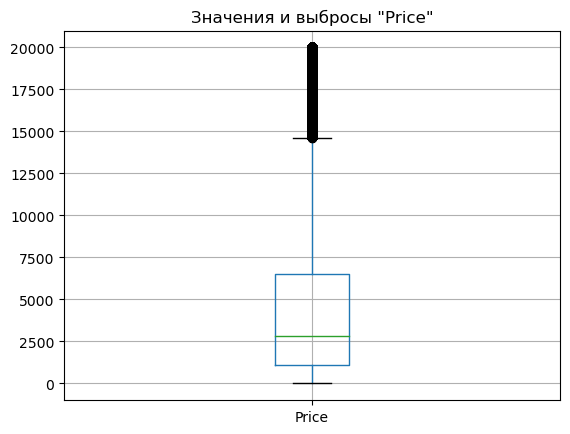

In [25]:
plt.title('Значения и выбросы "Price"')
pd.DataFrame(data=data['Price']).boxplot();

<div class="alert alert-info" style="border:solid purple 2px; padding: 20px; background-color: #e6d2f2; color: #4b0082;">

У значений цены нет нижних выбросов, есть только верхние. Удалю их.

In [26]:
data['Price'].describe()

count    309329.000000
mean       4486.937196
std        4564.852796
min           0.000000
25%        1100.000000
50%        2800.000000
75%        6500.000000
max       20000.000000
Name: Price, dtype: float64

<div class="alert alert-info" style="border:solid purple 2px; padding: 20px; background-color: #e6d2f2; color: #4b0082;">

Найду значение 100%.

1) (75% - 25%) * 1.5 = (6500 - 1100) * 1.5 = 8100
2) 75% + 8100 = 6500 + 8100 = 14600

<div class="alert alert-info" style="border:solid purple 2px; padding: 20px; background-color: #e6d2f2; color: #4b0082;">

На графике видно, что диапазон значений включает в себя область около нуля. Рассмотрю её подробнее.

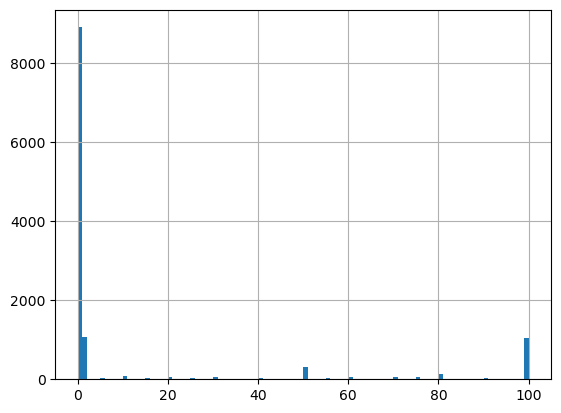

In [27]:
data['Price'].hist(range = (0, 100), bins = 100);

<div class="alert alert-info" style="border:solid purple 2px; padding: 20px; background-color: #e6d2f2; color: #4b0082;">

Можно заметить большой пик нулевых значений. Цена не может быть нулевой, поэтому удалю эти значения.

In [28]:
data = data.query('Price <= 14600 and Price > 100')

In [29]:
data.shape

(280957, 10)

**б)** RegistrationYear

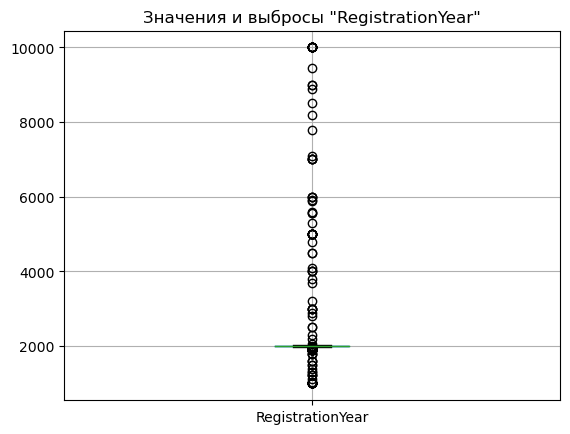

In [30]:
plt.title('Значения и выбросы "RegistrationYear"')
pd.DataFrame(data=data['RegistrationYear']).boxplot();

<div class="alert alert-info" style="border:solid purple 2px; padding: 20px; background-color: #e6d2f2; color: #4b0082;">

В данных присутствует небольшое количество выбросов. Рассмотрю уникальные значения.

In [31]:
data['RegistrationYear'].sort_values(ascending=False).unique()

array([9999, 9450, 9000, 8888, 8500, 8200, 7800, 7100, 7000, 6000, 5911,
       5900, 5600, 5555, 5300, 5000, 4800, 4500, 4100, 4000, 3800, 3700,
       3200, 3000, 2900, 2800, 2500, 2290, 2200, 2066, 2019, 2018, 2017,
       2016, 2015, 2014, 2013, 2012, 2011, 2010, 2009, 2008, 2007, 2006,
       2005, 2004, 2003, 2002, 2001, 2000, 1999, 1998, 1997, 1996, 1995,
       1994, 1993, 1992, 1991, 1990, 1989, 1988, 1987, 1986, 1985, 1984,
       1983, 1982, 1981, 1980, 1979, 1978, 1977, 1976, 1975, 1974, 1973,
       1972, 1971, 1970, 1969, 1968, 1967, 1966, 1965, 1964, 1963, 1962,
       1961, 1960, 1959, 1958, 1957, 1956, 1955, 1954, 1953, 1952, 1951,
       1950, 1949, 1948, 1946, 1945, 1944, 1943, 1942, 1941, 1940, 1938,
       1937, 1936, 1935, 1934, 1932, 1931, 1930, 1929, 1928, 1925, 1923,
       1910, 1800, 1602, 1600, 1500, 1400, 1300, 1234, 1111, 1039, 1001,
       1000], dtype=int64)

<div class="alert alert-info" style="border:solid purple 2px; padding: 20px; background-color: #e6d2f2; color: #4b0082;">

Данные меньше 1910 и больше 2016 - очевидно, выбросы. Удалю их, т.к. их небольшое количество и этот признак сильно влияет на цену.

In [32]:
data = data.query('RegistrationYear <= 2016 & RegistrationYear > 1922')

**в)** Power

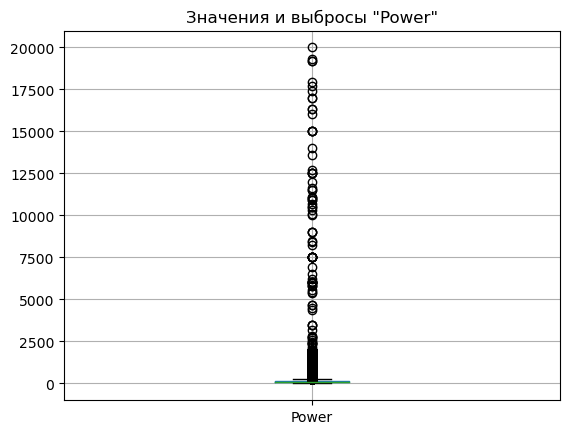

In [33]:
plt.title('Значения и выбросы "Power"')
pd.DataFrame(data=data['Power']).boxplot();

In [34]:
data['Power'].describe()

count    268345.000000
mean        109.484164
std         197.958455
min           0.000000
25%          69.000000
50%         103.000000
75%         140.000000
max       20000.000000
Name: Power, dtype: float64

<div class="alert alert-info" style="border:solid purple 2px; padding: 20px; background-color: #e6d2f2; color: #4b0082;">

1) найду межквартильный размах: (75% - 25%) * 1,5 = (143 - 73) * 1,5 = 105

2) найду значение 100%: 75% + 111 = 143 + 105 = 248 - граница нормального размаха. Значения выше её - выбросы. Рассмотрю область нормальных значений

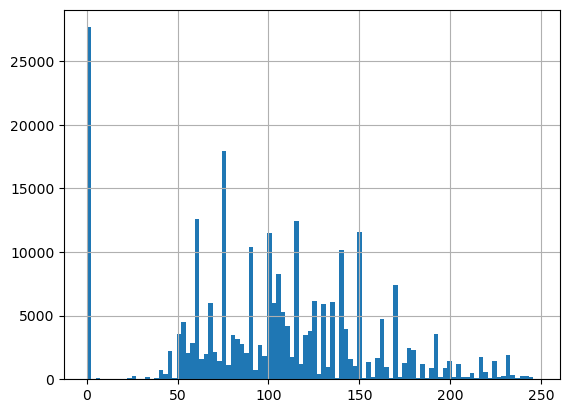

In [35]:
data['Power'].hist(range=(0, 248), bins=100);

<div class="alert alert-info" style="border:solid purple 2px; padding: 20px; background-color: #e6d2f2; color: #4b0082;">

На графике видно большое количество нулей и то, что большее количество значений находится в диапазоне от 50 до 150. Предположу, что значения от 500 до 1500 имеют ошибку в один 0, значения от 5000 до 15000 имеют ошибку в два 0. Исправлю эти ошибки.

In [36]:
data.loc[(data['Power'] >= 500) & (data['Power'] <= 1500), 'Power'] *= 0.1
data.loc[(data['Power'] >= 5000) & (data['Power'] <= 15000), 'Power'] *= 0.01

In [37]:
#удалим выбросы
data = data.query('Power <= 251')

<div class="alert alert-info" style="border:solid purple 2px; padding: 20px; background-color: #e6d2f2; color: #4b0082;">

Заменю нулевые значения медианными по соответствующим заводским характеристикам - бренду, модели, типу коробки передач и типу топлива.

In [38]:
data['Factory'] = data['Brand'] + ' ' + data['Model'] + ' ' + data['Gearbox'] + ' ' + data['FuelType']

In [39]:
for i in data['Factory'].unique():
    median = data.loc[data['Factory'] == i, 'Power'].median()
    data.loc[(data['Factory'] == i) & (data['Power'] == 0), 'Power'] = median

In [40]:
data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,Factory
0,480,other,1993,manual,90.0,golf,150000,petrol,volkswagen,unknown,volkswagen golf manual petrol
2,9800,suv,2004,auto,163.0,grand,125000,gasoline,jeep,unknown,jeep grand auto gasoline
3,1500,small,2001,manual,75.0,golf,150000,petrol,volkswagen,no,volkswagen golf manual petrol
4,3600,small,2008,manual,69.0,fabia,90000,gasoline,skoda,no,skoda fabia manual gasoline
5,650,sedan,1995,manual,102.0,3er,150000,petrol,bmw,yes,bmw 3er manual petrol


In [41]:
data = data.query('Power >= 4.2')

<div class="alert alert-info" style="border:solid purple 2px; padding: 20px; background-color: #e6d2f2; color: #4b0082;">

Узнаю самую маленькую мощность машины - 4.2 л.с. Ограничу данные этим значением.

In [42]:
data.shape

(257821, 11)

In [43]:
data = data.drop('Factory', axis=1)

**г)** Kilometer

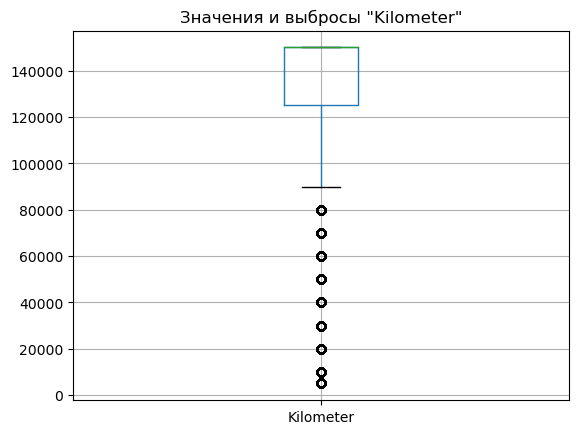

In [44]:
plt.title('Значения и выбросы "Kilometer"')
pd.DataFrame(data=data['Kilometer']).boxplot();

In [45]:
data['Kilometer'].describe()

count    257821.000000
mean     129472.696173
std       35937.746936
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Kilometer, dtype: float64

<div class="alert alert-info" style="border:solid purple 2px; padding: 20px; background-color: #e6d2f2; color: #4b0082;">

1) найду межквартильный размах: (75% - 25%) * 1,5 = (150000 - 125000) * 1,5 = 37500

2) найду значение 0%: 25% - 37500 = 125000 - 37500 = 87500 - граница нормального размаха. Значения выше её - выбросы, но подозрительными являются только слишком большие значения, поэтому оставлю данные без изменений.

In [46]:
data.shape

(257821, 10)

In [47]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 257821 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Price             257821 non-null  int64  
 1   VehicleType       257821 non-null  object 
 2   RegistrationYear  257821 non-null  int64  
 3   Gearbox           257821 non-null  object 
 4   Power             257821 non-null  float64
 5   Model             257821 non-null  object 
 6   Kilometer         257821 non-null  int64  
 7   FuelType          257821 non-null  object 
 8   Brand             257821 non-null  object 
 9   Repaired          257821 non-null  object 
dtypes: float64(1), int64(3), object(6)
memory usage: 21.6+ MB


<div class="alert alert-info" style="border:solid purple 2px; padding: 20px; background-color: #e6d2f2; color: #4b0082;">

**Вывод:** я произвела предобработку данных. До предобработки было 354369 строк и 16 столбцов. В предобработке я:
- удалила неинформативные данные
- проверила данные на дубликаты и удалила их
- проверила признаки на корреляцию с целевым признаком
- изучила и устранила пропуски
- изучила и устранила аномалии

После предобработки осталось 257821 строк и 10 столбцов.

## Обучение моделей

**1. Подготовлю выборки для обучения моделей.**

In [48]:
#выделим количественные и категориальные признаки

numeric = ['RegistrationYear', 'Power', 'Kilometer']
categoric = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']

In [49]:
#т.к. дальше в коде появляется ошибка из-за того, что три объекта со значением Model = "serie_3" есть только в тестовой выборке,
#удалим их, т.к. их всего три

data = data.query('Model != "serie_3"')

In [50]:
#разделим данные на признаки и целевой признак
features = data.drop('Price', axis=1)
target = data['Price']

#выделим тестовую выборку
features_train, features_test, target_train, target_test = \
train_test_split(features, target, test_size=0.25, random_state=12345)

In [51]:
#выделим тестовую и валидационную выборки для линейной регрессии
features_train_linear, features_test_linear, target_train_linear, target_test_linear = \
train_test_split(features, target, test_size=0.2, random_state=12345)

features_train_linear, features_valid_linear, target_train_linear, target_valid_linear = \
train_test_split(features_train_linear, target_train_linear, test_size=0.25, random_state=12345)

**2. Преобразую категориальные данные двумя способами для линейной регрессии и остальных моделей.**

**2.1.** OHE

In [53]:
ohe_variable = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first')
ohe_variable.fit(features_train[categoric])

features_train_ohe = pd.DataFrame(
    data=ohe_variable.transform(features_train[categoric]), 
    index=features_train.index,
    columns=ohe_variable.get_feature_names_out()
)

features_train_ohe = features_train_ohe.merge(features_train[numeric], left_index=True, right_index=True)

features_test_ohe = pd.DataFrame(
    data=ohe_variable.transform(features_test[categoric]),
    index=features_test.index,
    columns=ohe_variable.get_feature_names_out()
)

features_test_ohe = features_test_ohe.merge(features_test[numeric], left_index=True, right_index=True)

<div class="alert alert-info" style="border:solid purple 2px; padding: 20px; background-color: #e6d2f2; color: #4b0082;">

Преобразую выборки для линейной регрессии.

In [54]:
ohe_variable = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first')
ohe_variable.fit(features_train_linear[categoric])

#тренировочная выборка
features_train_linear_ohe = pd.DataFrame(
    data=ohe_variable.transform(features_train_linear[categoric]), 
    index=features_train_linear.index,
    columns=ohe_variable.get_feature_names_out()
)

features_train_linear_ohe = features_train_linear_ohe.merge(features_train_linear[numeric], left_index=True, right_index=True)

#валидационная выборка
features_valid_linear_ohe = pd.DataFrame(
    data=ohe_variable.transform(features_valid_linear[categoric]), 
    index=features_valid_linear.index,
    columns=ohe_variable.get_feature_names_out()
)

features_valid_linear_ohe = features_valid_linear_ohe.merge(features_valid_linear[numeric], left_index=True, right_index=True)

#тестовая выборка
features_test_linear_ohe = pd.DataFrame(
    data=ohe_variable.transform(features_test_linear[categoric]), 
    index=features_test_linear.index,
    columns=ohe_variable.get_feature_names_out()
)

features_test_linear_ohe = features_test_linear_ohe.merge(features_test_linear[numeric], left_index=True, right_index=True)

C:\Users\Naiana\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Naiana\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [55]:
features_train_ohe.head()

,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,Gearbox_manual,Gearbox_unknown,Model_145,...,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,Repaired_unknown,Repaired_yes,RegistrationYear,Power,Kilometer
78984,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1999,136.0,150000
115789,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1992,54.0,150000
281031,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1999,140.0,150000
345244,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2006,177.0,150000
109470,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,2007,140.0,150000


In [56]:
pd.options.mode.chained_assignment = None

scaler = StandardScaler()
scaler.fit(features_train_ohe)

features_train_ohe = scaler.transform(features_train_ohe)
features_test_ohe = scaler.transform(features_test_ohe)

**2.2.** Ordinal Encoder

In [57]:
encoder = OrdinalEncoder()
features_train_ordinal = pd.DataFrame(encoder.fit_transform(features_train[categoric]), \
                                      index=features_train.index,\
                                      columns=categoric)

features_train_ordinal = features_train_ordinal.merge(features_train[numeric], left_index=True, right_index=True)

features_test_ordinal = pd.DataFrame(encoder.fit_transform(features_test[categoric]),\
                                     index=features_test.index,\
                                     columns=categoric)

features_test_ordinal = features_test_ordinal.merge(features_test[numeric], left_index=True, right_index=True)

In [58]:
features_train_ordinal.head()

,VehicleType,Gearbox,Model,FuelType,Brand,Repaired,RegistrationYear,Power,Kilometer
78984,7.0,1.0,164.0,6.0,24.0,2.0,1999,136.0,150000
115789,5.0,2.0,173.0,6.0,38.0,0.0,1992,54.0,150000
281031,7.0,0.0,229.0,6.0,39.0,0.0,1999,140.0,150000
345244,7.0,1.0,44.0,2.0,36.0,2.0,2006,177.0,150000
109470,7.0,1.0,170.0,2.0,38.0,1.0,2007,140.0,150000


In [59]:
pd.options.mode.chained_assignment = None

scaler = StandardScaler()
scaler.fit(features_train_ordinal)

features_train_ordinal = scaler.transform(features_train_ordinal)
features_test_ordinal = scaler.transform(features_test_ordinal)

**3. Обучу модели**

**3.1.** Дерево решений

In [60]:
scorer = make_scorer(mean_squared_error)

<div class="alert alert-info" style="border:solid purple 2px; padding: 20px; background-color: #e6d2f2; color: #4b0082;">

С помощью GridSearchCV найду лучшее значение максимальной глубины.

In [61]:
#decision_tree_parameters = {'max_depth': range(1, 15, 1)}
#model = DecisionTreeRegressor(random_state=12345)

#grid = GridSearchCV(model, decision_tree_parameters, cv=5)
#grid.fit(features_train_ordinal, target_train)
#grid.best_params_

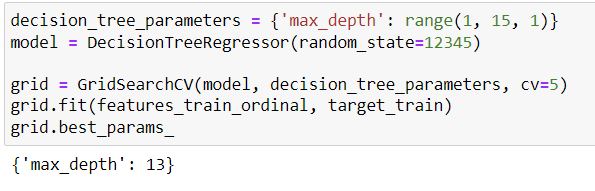

<div class="alert alert-info" style="border:solid purple 2px; padding: 20px; background-color: #e6d2f2; color: #4b0082;">

Лучшее значение максимальной глубины для модели дерева решений - 13.

**3.2.** Случайный лес

<div class="alert alert-info" style="border:solid purple 2px; padding: 20px; background-color: #e6d2f2; color: #4b0082;">

С помощью GridSearchCV найду лучшее значение количества деревьев.

In [62]:
#random_forest_parameters = {'n_estimators': range(10, 101, 10)}
#model = RandomForestRegressor(random_state=12345)

#grid = GridSearchCV(model, random_forest_parameters, cv=3)
#grid.fit(features_train_ordinal, target_train)
#grid.best_params_

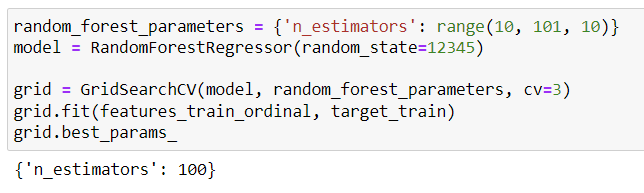

<div class="alert alert-info" style="border:solid purple 2px; padding: 20px; background-color: #e6d2f2; color: #4b0082;">

Лучшее значение количества деревьев для модели случайного леса - 100.

**3.3.** Линейная регрессия

In [63]:
#model = LinearRegression()
#rmse = (cross_val_score(model, features_train_ordinal, target_train, scoring=scorer) ** 0.5).mean()
#print(rmse)

<div class="alert alert-info" style="border:solid purple 2px; padding: 20px; background-color: #e6d2f2; color: #4b0082;">

RMSE модели линейной регрессии превышает порог 2500. RMSE линейной регрессии значительно превышает RMSE дерева решений и случайного леса.

**3.4.** LightGBM

<div class="alert alert-info" style="border:solid purple 2px; padding: 20px; background-color: #e6d2f2; color: #4b0082;">

Установлю LightGBM

In [64]:
!pip install lightgbm

In [65]:
model = lgb.LGBMRegressor(random_state=12345)

<div class="alert alert-info" style="border:solid purple 2px; padding: 20px; background-color: #e6d2f2; color: #4b0082;">

Подберу для модели лучшие гиперпараметры с помощью GridSearchCV.

In [66]:
lightgbm_parameters = {
    'n_estimators': range(10, 101, 10),
    'max_depth': range(1, 15, 1)
}

In [67]:
#grid = GridSearchCV(model, lightgbm_parameters, cv=5)
#grid.fit(features_train_ordinal, target_train)
#grid.best_params_

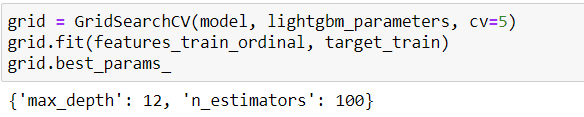

<div class="alert alert-info" style="border:solid purple 2px; padding: 20px; background-color: #e6d2f2; color: #4b0082;">

Лучшие значения максимальной глубины - 12, количества деревьев - 100 для модели LightGBM.

## Анализ моделей

<div class="alert alert-info" style="border:solid purple 2px; padding: 20px; background-color: #e6d2f2; color: #4b0082;">

Проанализирую модели.

**1. Дерево решений**

<div class="alert alert-info" style="border:solid purple 2px; padding: 20px; background-color: #e6d2f2; color: #4b0082;">

Я выбрала модель дерева решений с глубиной 13.

In [68]:
model = DecisionTreeRegressor(max_depth=13, random_state=12345)
rmse = (cross_val_score(model, features_train_ordinal, target_train, scoring=scorer) ** 0.5).mean()
print('RMSE дерева решений:', rmse)

RMSE дерева решений: 1581.2458497061666


In [69]:
%%time

#время обучения
model.fit(features_train_ordinal, target_train)

CPU times: total: 438 ms
Wall time: 419 ms


DecisionTreeRegressor(max_depth=13, random_state=12345)

In [70]:
%%time

#время предсказания
predicted_train_ordinal = model.predict(features_train_ordinal)

CPU times: total: 31.2 ms
Wall time: 31.8 ms


In [71]:
decision_tree_list = [1.14, 0.109, 1.249, 1581.25]

**2. Случайный лес**

<div class="alert alert-info" style="border:solid purple 2px; padding: 20px; background-color: #e6d2f2; color: #4b0082;">

Я выбрала модель дерева решений с глубиной 13 и количеством деревьев 100.

In [72]:
model = RandomForestRegressor(max_depth=13, n_estimators=100, random_state=12345)
rmse = (cross_val_score(model, features_train_ordinal, target_train, scoring=scorer) ** 0.5).mean()
print('RMSE случайного леса:', rmse)

RMSE случайного леса: 1433.1174580425452


In [73]:
%%time

#время обучения
model.fit(features_train_ordinal, target_train)

CPU times: total: 24.1 s
Wall time: 24.1 s


RandomForestRegressor(max_depth=13, random_state=12345)

In [74]:
%%time

#время предсказания
predicted_train_ordinal = model.predict(features_train_ordinal)

CPU times: total: 1.98 s
Wall time: 1.99 s


In [75]:
random_forest_list = [28.2, 2.05, 30.25, 1433.12]

**3. Линейная регрессия**

In [76]:
#model = LinearRegression()
#rmse = cross_val_score(model, features_train_ohe, target_train, scoring=scorer) ** 0.5
#rmse

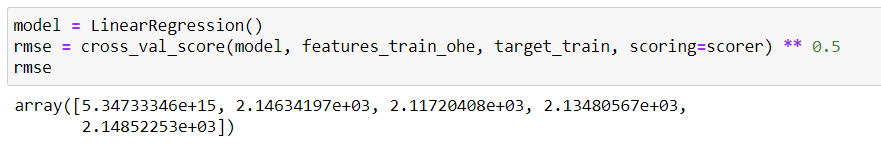

In [77]:
model = LinearRegression()
model.fit(features_train_linear_ohe, target_train_linear)
predicted_valid_linear_ohe = model.predict(features_valid_linear_ohe)

rmse = mean_squared_error(predicted_valid_linear_ohe, target_valid_linear) ** 0.5
print('RMSE линейной регрессии:', rmse)

RMSE линейной регрессии: 2135.3890606795567


In [78]:
%%time

#время обучения
model.fit(features_train_ohe, target_train)

CPU times: total: 18.1 s
Wall time: 6.28 s


LinearRegression()

In [79]:
%%time

#время предсказания
predicted_train_ohe = model.predict(features_train_ohe)

CPU times: total: 625 ms
Wall time: 165 ms


In [80]:
linear_regression_list = [19.7, 0.203, 19.903, 2135.39]

**4. LightGBM**

<div class="alert alert-info" style="border:solid purple 2px; padding: 20px; background-color: #e6d2f2; color: #4b0082;">

Я выбрала модель LightGBM с глубиной 12 и количеством деревьев 100.

In [81]:
model = lgb.LGBMRegressor(max_depth=12, n_estimators=100, random_state=12345)
rmse = (cross_val_score(model, features_train_ordinal, target_train, scoring=scorer) ** 0.5).mean()
print('RMSE LightGBM:', rmse)

RMSE LightGBM: 1402.5141072489073


In [82]:
%%time

#время обучения
model.fit(features_train_ordinal, target_train)

CPU times: total: 4.03 s
Wall time: 573 ms


LGBMRegressor(max_depth=12, random_state=12345)

In [83]:
%%time

#время предсказания
predicted_train_ordinal = model.predict(features_train_ordinal)

CPU times: total: 1.52 s
Wall time: 209 ms


In [84]:
light_gbm_list = [3.36, 1.31, 4.67, 1402.51]

**5. Подведу итоги**

In [85]:
pd.DataFrame(data = {
    'Decision Tree': decision_tree_list,
    'Random Forest': random_forest_list,
    'Linear Regression': linear_regression_list,
    'LightGBM': light_gbm_list,
},
            index=['Время обучения', 'Время предсказания', 'Общее время', 'RMSE'])

,Decision Tree,Random Forest,Linear Regression,LightGBM
Время обучения,1.140,28.20,19.700,3.36
Время предсказания,0.109,2.05,0.203,1.31
Общее время,1.249,30.25,19.903,4.67
RMSE,1581.250,1433.12,2135.390,1402.51


In [86]:
pd.DataFrame(data = {
    'Decision Tree': ['очень высокая', 'очень высокая', 'очень высокая', 'высокое'],
    'Random Forest': ['низкая', 'очень высокая', 'низкая', 'среднее'],
    'Linear Regression': ['низкая', 'очень высокая', 'низкая', 'низкая'],
    'LightGBM': ['высокая', 'очень высокая', 'высокое', 'очень высокое'],
},
            index=['Скорость обучения', 'Скорость предсказания', 'Общая скорость', 'Качество'])

,Decision Tree,Random Forest,Linear Regression,LightGBM
Скорость обучения,очень высокая,низкая,низкая,высокая
Скорость предсказания,очень высокая,очень высокая,очень высокая,очень высокая
Общая скорость,очень высокая,низкая,низкая,высокое
Качество,высокое,среднее,низкая,очень высокое


<div class="alert alert-info" style="border:solid purple 2px; padding: 20px; background-color: #e6d2f2; color: #4b0082;">

Заказчику можно предложить модель **LightGBM с максимальной глубиной 12 и количеством деревьев 100**, т.к. скорость работы у неё высокая, а качество очень высокое.

<div class="alert alert-info" style="border:solid purple 2px; padding: 20px; background-color: #e6d2f2; color: #4b0082;">

Вывод: в этом разделе я подобрала гиперпараметры для моделей дерева решений, случайного леса и LightGBM с помощью GridSearchCV. Лучшими оказались:
- Дерево решений: максимальная глубина - 13
- Случайный лес: количество деревьев - 100
- LightGBM: максимальная глубина - 12, количество деревьев - 100

Я нашла и проанализировала время обучения, время предсказания и качество модели. Модели дерева решений и случайного леса дали высокие и средние результаты соответственно, худший результат дала модель линейной регрессии, лучший - модель LightGBM.

## Тестирование лучшей модели

In [87]:
%%time

model = lgb.LGBMRegressor(max_depth=12, n_estimators=100, random_state=12345)
model.fit(features_train_ordinal, target_train)

CPU times: total: 2.75 s
Wall time: 405 ms


LGBMRegressor(max_depth=12, random_state=12345)

In [88]:
%%time

predicted_test_ordinal = model.predict(features_test_ordinal)

CPU times: total: 500 ms
Wall time: 92.6 ms


In [89]:
rmse = mean_squared_error(target_test, predicted_test_ordinal) ** 0.5
print('RMSE на тестовой выборке:', rmse)

RMSE на тестовой выборке: 1421.8535298681409


<div class="alert alert-info" style="border:solid purple 2px; padding: 20px; background-color: #e6d2f2; color: #4b0082;">

RMSE лучшей модели на тестовой выборке составило 1421.85, время обучения - 7.94 секунды, время предсказания - 1.28 секунды, общее время работы - 9.22 секунды.

<div class="alert alert-info" style="border:solid purple 2px; padding: 20px; background-color: #e6d2f2; color: #4b0082;">

**ОБЩИЙ ВЫВОД**

В проекте я:
1) произвела предобработку данных
- удалила неинформативные данные
- проверила данные на дубликаты и удалила их
- проверила признаки на корреляцию с целевым признаком
- изучила и устранила пропуски
- изучила и устранила аномалии

До предобработки было 354369 строк и 16 столбцов. После предобработки осталось 257821 строк и 10 столбцов.

2) изучила модели
- подобрала гиперпараметры для моделей дерева решений, случайного леса и LightGBM с помощью GridSearchCV
- нашла и проанализировала время обучения, время предсказания и качество модели

3) сделала выводы

- лучший результат дала модель LightGBM с максимальной глубиной 12 и количеством деревьев 100

- модель дерева решений дала высокий результат

- модель случайного леса дала средний результат

- я предложила заказчику модель LightGBM с максимальной глубиной 12 и количеством деревьев 100, т.к. скорость работы у неё высокая, а качество очень высокое. **RMSE лучшей модели на тестовой выборке составило 1421.85, время обучения - 7.94 секунды, время предсказания - 1.28 секунды, общее время работы - 9.22 секунды.**